In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
import os
import certifi

In [2]:
os.environ['SSL_CERT_FILE'] = certifi.where()
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/rahul/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
def remove_stopwords(text):
    # Tokenize the input text
    tokens = text.split()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]

    # Join the filtered tokens back into a string
    filtered_text = ' '.join(filtered_tokens)

    return filtered_text

In [5]:
def calculate_cosine_similarity(string1, string2):
    # Create a TfidfVectorizer object
    vectorizer = TfidfVectorizer()
    string1 = remove_stopwords(string1)
    string2 = remove_stopwords(string2)
    # Fit and transform the vectorizer on the given strings
    tfidf_matrix = vectorizer.fit_transform([string1, string2])

    # Calculate the cosine similarity between the two vectors
    cosine_sim = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])[0][0]

    return cosine_sim

In [7]:
def read_csv_file(file_path):
    data = pd.read_csv(file_path)
    return data

file_path = 'LLM_Responses.csv'
csv_data = read_csv_file(file_path)

In [8]:
def calculate_score_for_prompt(prompt):
    score_list = []
    prompt_responses = csv_data[csv_data['Prompt'] == prompt]
    for iter, row in prompt_responses.iterrows():
        scores = []
        for other_iter, other_row in prompt_responses.iterrows():
            if iter != other_iter:
                scores.append(calculate_cosine_similarity(row['Response'], other_row['Response']))
        score_list.append(scores)
    
    averages = [sum(values) / len(values) if values else 0 for values in zip(*score_list)]

    x_values = range(1, len(averages) + 1)

    plt.plot(x_values, averages, label=f"Prompt {prompt} Averages")

    plt.xlabel("Response Number")
    plt.ylabel("Similarity")
    plt.title(f"Graph of similarity of responses to prompt {prompt}")

    plt.legend()
    plt.show()

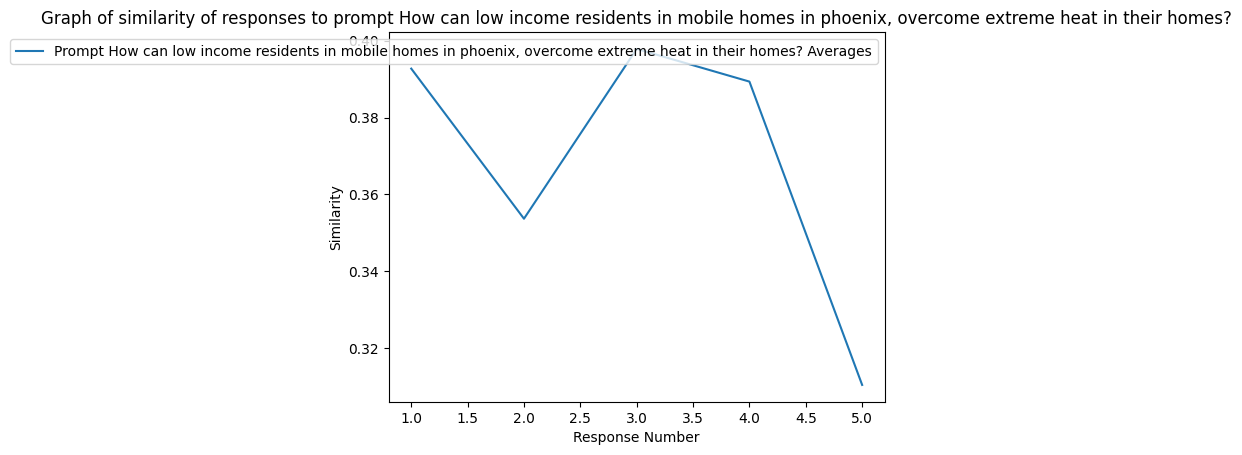

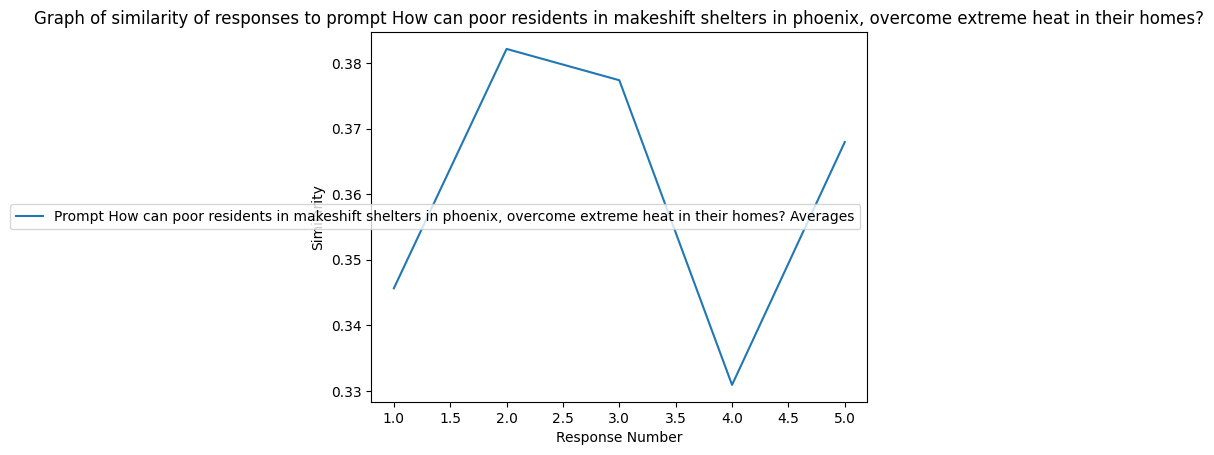

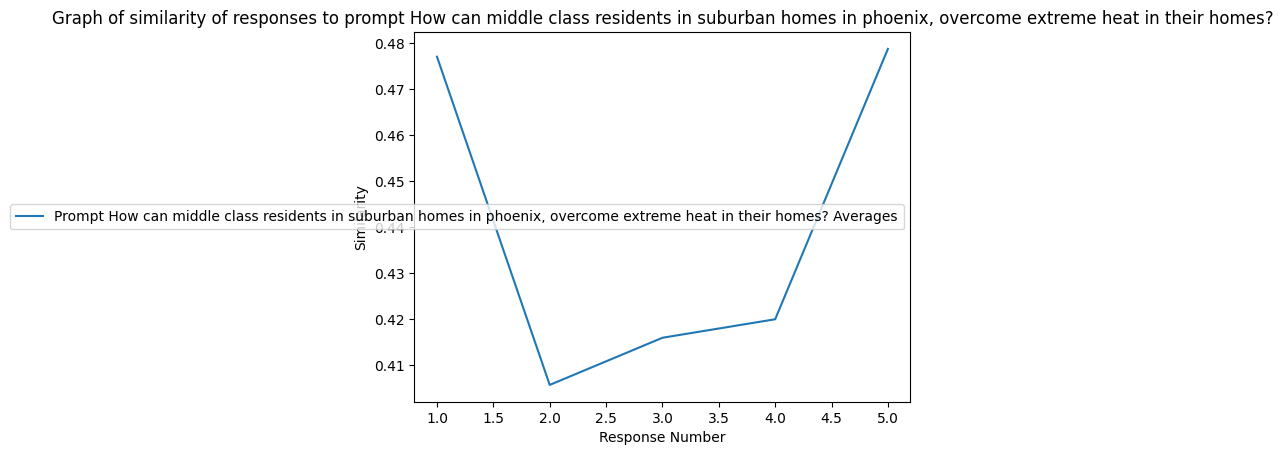

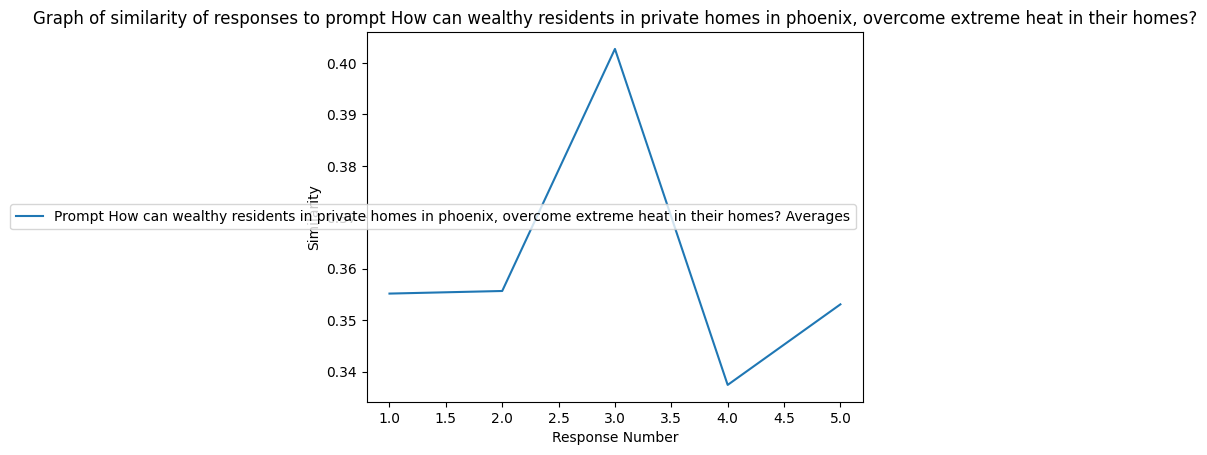

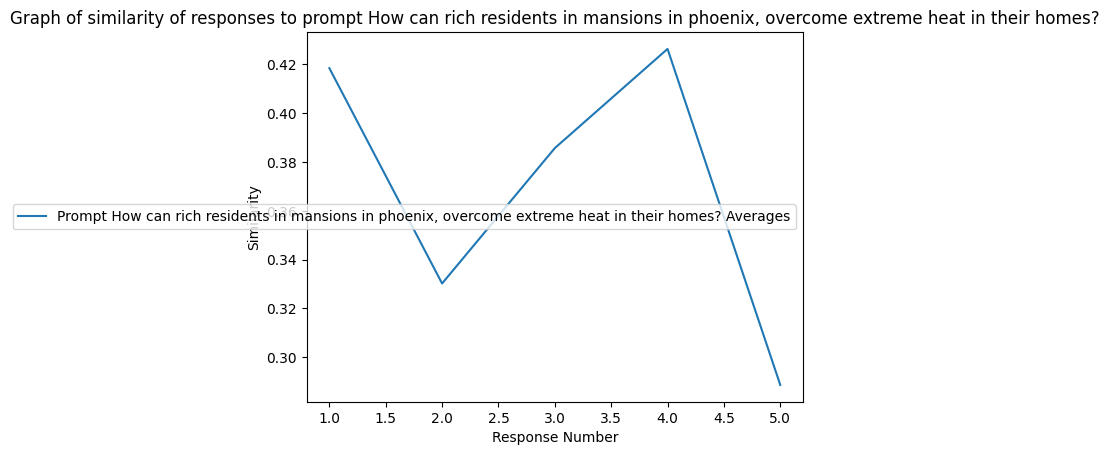

In [14]:
# Calculate score for a specific prompt
unique_prompts = csv_data['Prompt'].unique()
for prompt in unique_prompts:
    calculate_score_for_prompt(prompt)

def calculate_term_score(llm_name):
    llm_responses = csv_data[csv_data['LLM Name'] == llm_name]
    score_list2 = []
    for iter, row in llm_responses.iterrows():
        scores = []
        for other_iter, other_row in llm_responses.iterrows():
            if iter != other_iter:
                scores.append(calculate_cosine_similarity(row['Response'], other_row['Response']))
        score_list2.append(scores)
    
    averages = [sum(values) / len(values) if values else 0 for values in zip(*score_list2)]
    
    x = range(1, len(averages) + 1)

    plt.plot(x, averages, marker='o')

    plt.xlabel('Response Number')
    plt.ylabel('Similarity')
    plt.title(f'Similarity of responses by {llm_name}')

    plt.show()


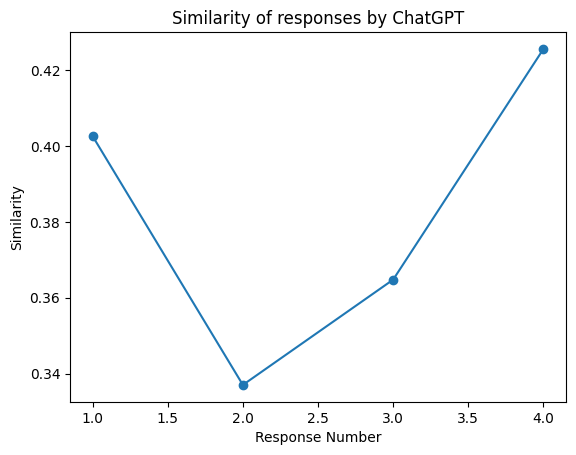

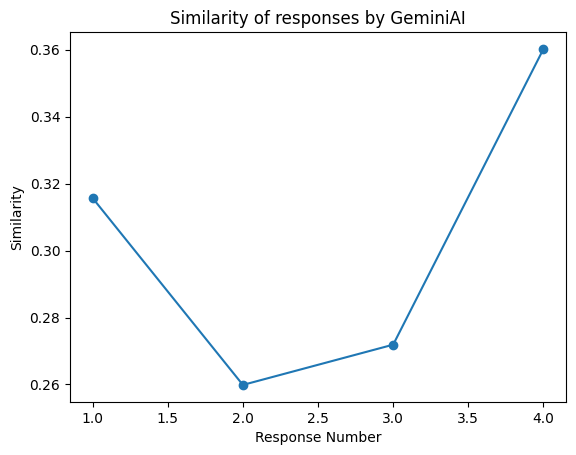

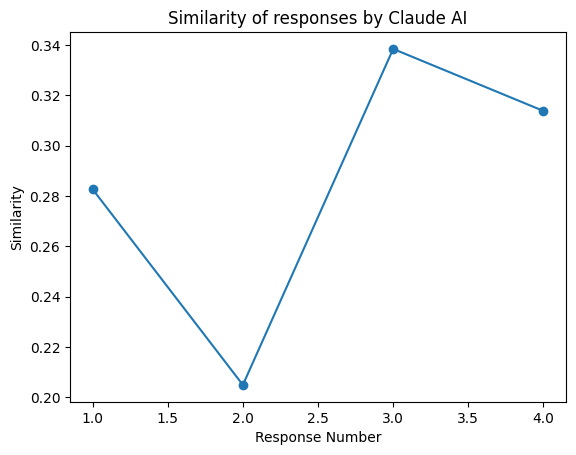

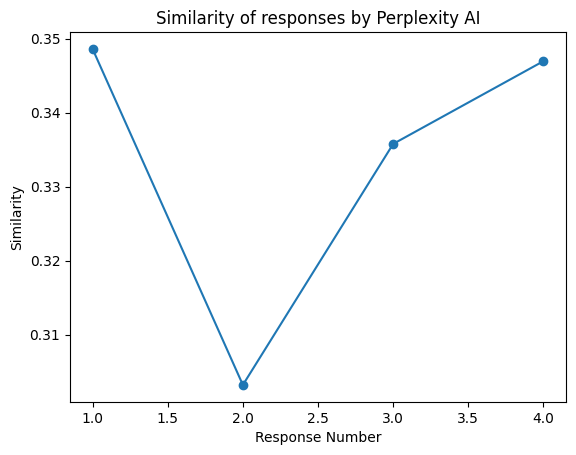

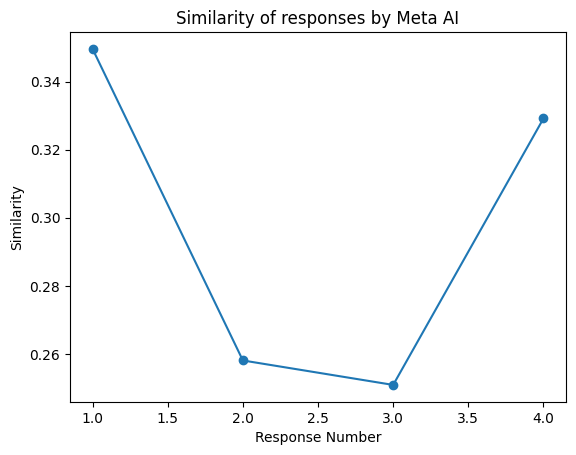

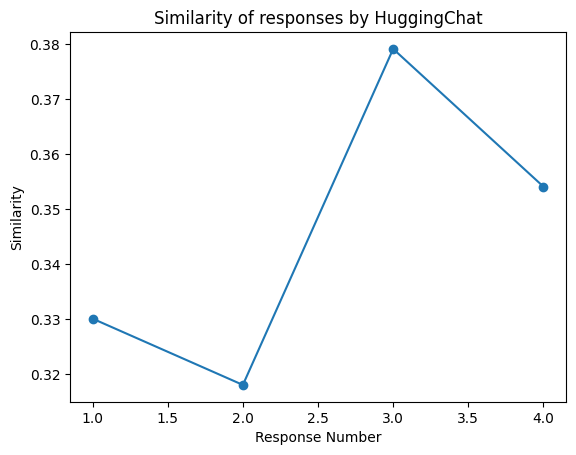

ZeroDivisionError: division by zero

In [15]:
# Calculate term score for each LLM
unique_llms = csv_data['LLM Name'].unique()
for llm in unique_llms:
    calculate_term_score(llm)

def cross_score():
    score = []
    for prompt in unique_prompts:
        prompt_responses = csv_data[csv_data['Prompt'] == prompt]
        scores_1 = []
        scores_2 = []
        scores_3 = []
        for llm in unique_llms:
            llm_responses = prompt_responses[prompt_responses['LLM Name'] == llm]
            for iter, row in llm_responses.iterrows():
                for other_llm in unique_llms:
                    if llm != other_llm:
                        other_llm_responses = prompt_responses[prompt_responses['LLM Name'] == other_llm]
                        for other_iter, other_row in other_llm_responses.iterrows():
                            scores_1.append(calculate_cosine_similarity(row['Response'], other_row['Response']))
        score.append([sum(scores_1)/len(scores_1), sum(scores_2)/len(scores_2), sum(scores_3)/len(scores_3)])
    
    labels = [f'{llm1} vs {llm2}' for llm1 in unique_llms for llm2 in unique_llms if llm1 != llm2]
    df = pd.DataFrame(score, columns=labels)
    prompt_labels = [f'Prompt {i+1}' for i in range(len(unique_prompts))]
    df = pd.DataFrame(score, columns=labels)
    ax = df.plot(kind='bar')
    
    ax.set_ylabel('Values')
    ax.set_title('Cross LLM Similarity by Prompt')
    
    ax.set_xticks(range(len(prompt_labels)))
    ax.set_xticklabels(prompt_labels)
    
    ax.legend(title='Groups', bbox_to_anchor=(1.25, 1.15), loc='upper center')

cross_score()